# Q-Learning in Reinforcement Learning

Let us use gym to conduct the following practice of CartPole.

The description can be found [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

**Action Space** - Type : ```Discrete(2)```

- ```0``` : Push cart to the left
- ```1``` : Push cart to the right

**Observation Space** - Type : ```Box(-num, num, (4,), float32)```

- Cart Position ```(-4.8, 4.8)```
- Cart Velocity ```(-inf, inf)```
- Pole Angle ```(-0.41, 0.41)```
- Pole Velocity At Tip ```(-inf, inf)```

**Reward** - Type : ```float32```

It always returns ```1.0``` as reward.<br>
If completely succeeded, you can then take max ```500.0``` rewards in a single episode, because a single episode will be truncated on max ```500``` actions.

**Done Flag (Termination and Truncation)** - Type : ```bool```

It returns the following 2 types of done flag, which is used to check whether the episode is done or not.

- Termination flag : When the agent fails and cannot work any more, termination flag is ```True```, otherwise ```False```.
- Truncation flag : When the agent reaches to max 500 actions (successful at final action), truncation flag is ```True```, otherwise ```False```. (The agent cannot work any more, also in this case.)



To start the experiments, first we need to load necessary libraries

In [3]:
import gymnasium as gym # Got this idea from the FAIML_2024 Discord server. Newest numpy does not support bool8. "gymnasium" is a newer version of "gym". This avoids the bool8 issue.
import numpy as np

**Step 1**: let us define the expected rewards as

$$ R = \sum_{t=0}^{\infty} {\gamma^t r_t} $$

where $ r_t $ is a reward value obtained at t and $\gamma$ is discount.
For instnace, when you try to grab an object, you will do the following 3 actions:

    - action #1 : Stretch your arm (t=0),
      Getting reward 0,
    - action #2 : Open your hand (t=1),
      Getting reward 0,
    - action #3 : Grab an object (t=2),
      Getting reward 10,
    
**${\color{red}{Task 1.}}$** please calculate the reward for $R_{t=0},\ R_{t=1}$ and $R_{t=2}$ when $\gamma$ = 0.99

Q-value is based on this idea of expected cumulative reward. Depending on each state (observation), the each action will have the corresponding expected reward.

In above example, if you see an object in front of you (i.e, the **state** of "you see an object"), the **action** "stretching your arm" will have high value of expected reward. However, if you cannot see an object anywhere, the action "stretching your arm" will have low value of expected reward.

Q-value of each corresponding state and action is denoted as $Q(s,a)$. Suppose both action and state has 1 dimension of discrete values, $Q(s,a)$ will be written as as Q-table as follows,

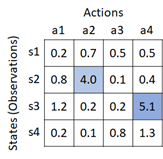

In practice, both action space and observation space may have more than 1 dimension. For instance, in **CartPole** example, the returned state (observation) has 4 elements of float values, i.e, 4 dimensions. Then Q-Table will be the combination of 1 dimension (action space) and 4 dimension (observation space).

In Q-Learning, we optimize this table by the following iterative updates $t=0,1,2,,...$. In the following equation, $Q_t(s_t,a_t)$ is used to update $Q_{t+1}(s_{t+1},a_{t+1})$ as,

$$Q_{t+1}(s_{t+1},a_{t+1})=Q_t(s_t,a_t)+\alpha \left( r_t+\gamma\max_a Q_t(s_{t+1},a)-Q_t(s_t,a_t)  \right)$$

where $\alpha$ is the learning rate

**Step 2.** CartPole has 4 elements of continuos (float) observation space. In order for applying primitive Q-Learning, we should convert continuous state to discrete state (i.e, discretize). In this example, we will convert Tuple(Box, Box, Box, Box) into Tuple(Discrete(20), Discrete(20), Discrete(20), Discrete(20)) - which converts float value to the bin of value for each segment.

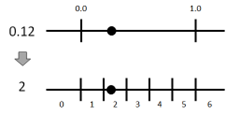

In [4]:
import math

env = gym.make("CartPole-v1")

new_observation_shape = (20, 20, 20, 20)

bins = []
for i in range(4):
    item = np.linspace(
        env.observation_space.low[i] if (i == 0) or (i == 2) else -4,
        env.observation_space.high[i] if (i == 0) or (i == 2) else 4,
        num=new_observation_shape[i],
        endpoint=False)
    item = np.delete(item, 0)
    bins.append(item)
    print(bins[i])

# define function to convert to discrete state
def get_discrete_state(s):
    new_s = []
    #s = s[0]
    for i in range(4):
        new_s.append(np.digitize(s[i], bins[i]))
    return new_s

[-4.32       -3.8400002  -3.3600001  -2.88       -2.4        -1.9200001
 -1.44       -0.96000004 -0.48000002  0.          0.48000002  0.96000004
  1.44        1.9200001   2.4         2.88        3.3599997   3.8400002
  4.3200006 ]
[-3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6
  2.   2.4  2.8  3.2  3.6]
[-0.37699112 -0.3351032  -0.29321533 -0.25132743 -0.20943952 -0.16755164
 -0.12566373 -0.08377582 -0.04188791  0.          0.04188788  0.08377576
  0.1256637   0.16755158  0.20943952  0.2513274   0.29321527  0.3351032
  0.3769911 ]
[-3.6 -3.2 -2.8 -2.4 -2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6
  2.   2.4  2.8  3.2  3.6]


**Step 3.** Now we generate Q-Table
 and initialize all values by 0. (Here it's 5 dimensional table.)

In [5]:
q_table = np.zeros(new_observation_shape + (env.action_space.n,))
q_table.shape

(20, 20, 20, 20, 2)

In [59]:
gamma = 0.99
alpha = 0.1
epsilon = 1
epsilon_decay = epsilon / 4000

# pick up action from q-table with greedy exploration
def pick_sample(s, epsilon):
    # get optimal action but with greedy exploration (to prevent picking up same values in the first stage)
    if np.random.random() > epsilon:
        a = np.argmax(q_table[tuple(s)])
    else:
        a = np.random.randint(0, env.action_space.n)
    return a

env = gym.make("CartPole-v1")
reward_records = []
for i in range(6000):
    # Run episode till done
    done = False
    total_reward = 0
    s = env.reset()[0] # error found. FAIML_2024 Discord server suggested to add "[0]" to fix this. This is so we would have 2 elements, instead of just 1.
    s_dis = get_discrete_state(s)
    while not done:
        a = pick_sample(s_dis, epsilon)
        s, r, term, trunc, _ = env.step(a) # env.step(a) returns 5 elements, not 4. I added the "_" to fix this. I don't know what it is, but it won't be used.
        done = term or trunc
        s_dis_next = get_discrete_state(s)

        # Update Q-Table
        maxQ = np.max(q_table[tuple(s_dis_next)])
        q_table[tuple(s_dis)][a] += alpha * (r + gamma * maxQ - q_table[tuple(s_dis)][a])

        s_dis = s_dis_next
        total_reward += r

    # Update epsilon for each episode
    if epsilon - epsilon_decay >= 0:
        epsilon -= epsilon_decay

    # Record total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, total_reward), end="\r")
    reward_records.append(total_reward)

print("\nDone")
env.close()

Run episode5999 with rewards 500.0
Done


**${\color{red}{Task 2.}}$** Use Matplotlib to plot the reward VS episode

Text(0, 0.5, 'Reward')

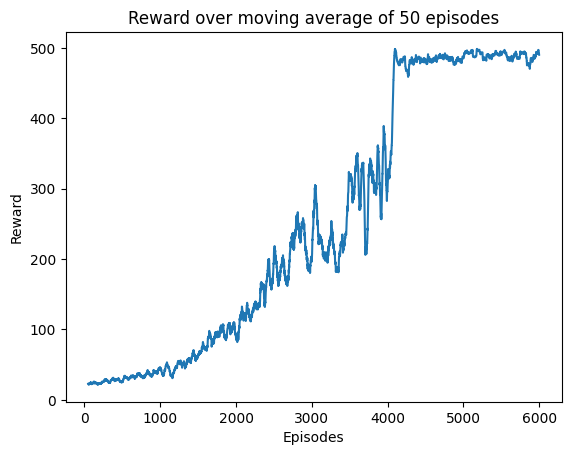

In [60]:
import matplotlib.pyplot as plt
# Plot all rewards and a 50 episode average i.e. a moving average over 50 episodes
average_reward = []
for i in range(50, len(reward_records)): # We take reward_records, then the average via np.mean of 50 episodes with [i-50:i], and then we append it to average_reward.
    average_reward.append(np.mean(reward_records[i-50:i])) # source used to help: https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/





plt.plot(range(50, len(reward_records)), average_reward)
plt.title("Reward over moving average of 50 episodes")
plt.xlabel("Episodes")
plt.ylabel("Reward")


**${\color{red}{Task 3.}}$** What can you observe from the plot of reward VS episode figure? Find the problem with Q-learning and provide one solution. Note that you need to provide at least one solution with a plot of reward VS episode to show your improvements or discovery. (Hint: Q-learning use greedy search and takes random actions during training. It may cause inefficiency)

In [63]:
# Play around with these parameters to see how they affect the learning, 
# try to find a better combination i.e. the reward gets to 500 faster than the previous model
gamma = 0.99
alpha = 0.0001
epsilon = 1
epsilon_decay = epsilon / 4000

# pick up action from q-table with greedy exploration
def pick_sample(s, epsilon):
    # get optimal action but with greedy exploration (to prevent picking up same values in the first stage)
    if np.random.random() > epsilon:
        a = np.argmax(q_table[tuple(s)])
    else:
        a = np.random.randint(0, env.action_space.n)
    return a

env = gym.make("CartPole-v1")
reward_records = []
for i in range(6000):
    # Run episode till done
    done = False
    total_reward = 0
    s = env.reset()[0]
    s_dis = get_discrete_state(s)
    while not done:
        a = pick_sample(s_dis, epsilon)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        s_dis_next = get_discrete_state(s)

        # Update Q-Table
        maxQ = np.max(q_table[tuple(s_dis_next)])
        q_table[tuple(s_dis)][a] += alpha * (r + gamma * maxQ - q_table[tuple(s_dis)][a])

        s_dis = s_dis_next
        total_reward += r

    # Update epsilon for each episode
    if epsilon - epsilon_decay >= 0:
        epsilon -= epsilon_decay

    # Record total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, total_reward), end="\r")
    reward_records.append(total_reward)

print("\nDone")
env.close()

Run episode5999 with rewards 500.0
Done


Do the same plot as above

Text(0, 0.5, 'Reward')

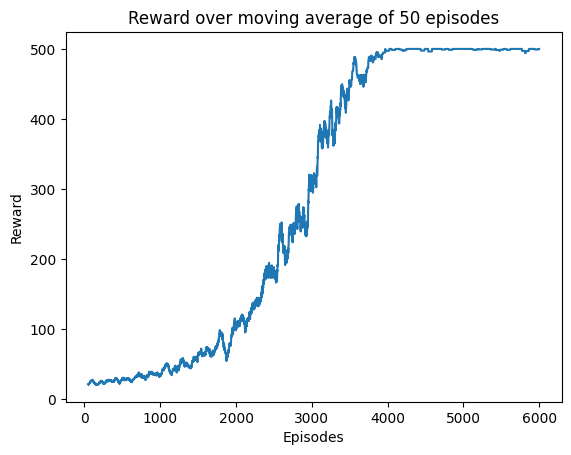

In [64]:
average_reward = []
for i in range(50, len(reward_records)): # We take reward_records, then the average via np.mean of 50 episodes with [i-50:i], and then we append it to average_reward.
    average_reward.append(np.mean(reward_records[i-50:i])) # source used to help: https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/





plt.plot(range(50, len(reward_records)), average_reward)
plt.title("Reward over moving average of 50 episodes")
plt.xlabel("Episodes")
plt.ylabel("Reward")

Gamma should almost be never changed, since from my observations gamma will affect the reward amount a lot. The less we have so far I've seen a pretty linear trend of it gowing down to some degree in maximum reward attainable. Gamma should stay at around 0.95 - 0.99 range.

The higher alpha is from what I've seen the more erratic the final result can be, and it gets typically worse results than if it was lower.

I've tried multiple alphas, and I've come to the conclusion that one run wouldn't be enough to determine if the value is effective or not.
So far I've noticed
alpha = 0.0001 having the best result. Getting to 500 before the 4000 mark. It seems to take longer to simulate, though.